In [1]:
'''
统计工具：
①自回归模型
②马尔科夫模型
③因果关系
'''
%matplotlib inline
import torch
from torch import nn
import d2l.torch as d2l
from torch.nn import functional as F

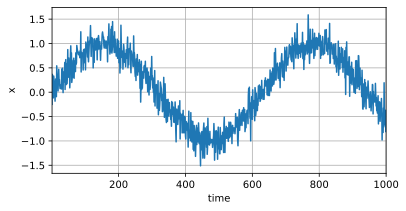

In [2]:
T = 1000 # 总共产生1000个点
time = torch.arange(1,T+1,dtype=torch.float32)
x = torch.sin(0.01*time) + torch.normal(0,0.2,(T,))
d2l.plot(time,[x],'time','x',xlim=[1,1000],figsize=(6,3))

In [3]:
# 将这个序列转换为模型的特征-标签对
tau = 4
features = torch.zeros((T-tau,tau))
for i in range(tau):
    features[:,i]=x[i:T-tau+i]
labels = x[tau:].reshape((-1,1))

In [4]:
batch_size,n_train = 16,600
# 只有前n_train个样本用于训练
train_iter = d2l.load_array((features[:n_train],labels[:n_train]),
                            batch_size,is_train=True)

In [5]:
# 使用一个相当简单的架构训练模型：
# 一个拥有两个全连接层的多层感知机，ReLU激活函数和平方损失


# 初始化网络权重和函数
def init_weight(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)

# 一个简单的多层感知机
def get_net():
    net = nn.Sequential(
        nn.Linear(4,10),
        nn.ReLU(),
        nn.Linear(10,1)
    )
    net.apply(init_weight)
    return net
# 平方损失。MSELoss计算平方误差时不带系数1/2
loss = nn.MSELoss(reduction='none')

In [6]:
# 训练模型
def train(net,train_iter,loss,epochs,lr):
    trainer = torch.optim.Adam(net.parameters(),lr)
    for epoch in range(epochs):
        for X,y in train_iter:
            trainer.zero_grad()
            l = loss(net(X),y)
            l.sum().backward()
            trainer.step()
        print(f'epoch{epoch+1},'
              f'loss:{d2l.evaluate_loss(net,train_iter,loss):f}')

In [7]:
net = get_net()
train(net,train_iter,loss,5,0.01)

epoch1,loss:0.066100
epoch2,loss:0.057974
epoch3,loss:0.051294
epoch4,loss:0.051548
epoch5,loss:0.053793


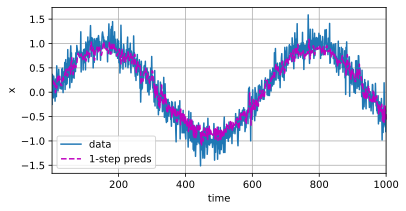

In [8]:
# 预测
onestep_preds = net(features)
d2l.plot([time,time[tau:]],
         [x.detach().numpy(),onestep_preds.detach().numpy()],'time',
         'x',legend=['data','1-step preds'],xlim=[1,1000],
         figsize=(6,3)
         )

# time[tau:]丢弃前tau个数据
# 1个x  2个y的表示

In [9]:
multistep_preds = torch.zeros(T)
multistep_preds[:n_train + tau] = x[:n_train+tau]
for i in range(n_train+tau,T):
    multistep_preds[i]=net(
        multistep_preds[i-tau:i].reshape((1,-1))
    )

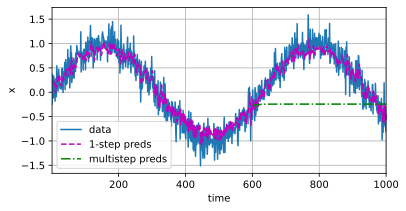

In [10]:
d2l.plot(
    [time,time[tau:],time[n_train+tau:]],
    [x.detach().numpy(),
     onestep_preds.detach().numpy(),
     multistep_preds[n_train+tau:].detach().numpy()],
    'time','x',legend=['data','1-step preds','multistep preds'],
    xlim=[1,1000],figsize=(6,3)
)

In [11]:
max_steps = 64
features = torch.zeros((T-tau-max_steps + 1,tau+max_steps))
# 列i(i＜tau)是来自x的观测，其时间步从（i）到（i+T-tau+max_steps+1）
for i in range(tau):
    features[:,i] = x[i:i+T-tau-max_steps+1]

# 列i(i＞tau)是来自(i-tau+1)步的预测，其时间步从（i）到（i+T-tau-max_steps+1）
for i in range(tau,tau+max_steps):
    features[:,i] = net(features[:,i-tau:i]).reshape(-1)


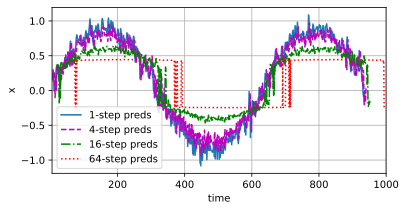

In [12]:
steps = (1,4,16,64)
d2l.plot([time[tau+i-1:T-max_steps+i] for i in steps],
         [features[:,tau+i-1].detach().numpy() for i in steps],
         'time','x',legend=[f'{i}-step preds' for i in steps],xlim=[5,1000],
         figsize=(6,3)
         )

In [13]:
# 文本预处理
import collections
import re
from d2l import torch as d2l

In [14]:
d2l.DATA_HUB['time_machine'] = (d2l.DATA_URL + 'timemachine.txt',
                                '090b5e7e70c295757f55df93cb0a180b9691891a')

In [15]:
def read_time_machine():
    # 将时间机器数据集加载到文本行的列表中
    with open(d2l.download('time_machine'),'r') as f:
        lines = f.readlines()
    return [re.sub('[^A-Za-z]+',' ',line).strip().lower() for line in lines]

In [16]:
lines = read_time_machine()
print(f'# 文本总行数：{len(lines)}')
print(lines[0])
print(lines[10])

正在从http://d2l-data.s3-accelerate.amazonaws.com/timemachine.txt下载../data/timemachine.txt...
# 文本总行数：3221
the time machine by h g wells
twinkled and his usually pale face was flushed and animated the


In [17]:
def tokenize(lines,token='word'):
    if token=='word':
        return [line.split() for line in lines]
    elif token == 'char':
        return [list(line) for line in lines]
    else:
        print('错误：未知词元类型：'+token)

In [18]:
tokens = tokenize(lines)
for i in range(11):
    print(tokens[i])

['the', 'time', 'machine', 'by', 'h', 'g', 'wells']
[]
[]
[]
[]
['i']
[]
[]
['the', 'time', 'traveller', 'for', 'so', 'it', 'will', 'be', 'convenient', 'to', 'speak', 'of', 'him']
['was', 'expounding', 'a', 'recondite', 'matter', 'to', 'us', 'his', 'grey', 'eyes', 'shone', 'and']
['twinkled', 'and', 'his', 'usually', 'pale', 'face', 'was', 'flushed', 'and', 'animated', 'the']


In [19]:
def count_corpus(tokens):
    # 统计词元的频率
    # 这里的tokens是1D列表或2D列表
    if len(tokens) == 0 or isinstance(tokens[0],list):
        # 将词元列表展开成一个列表
        tokens = [token for line in tokens for token in line]
    return collections.Counter(tokens)

In [22]:
class Vocab:
    def __init__(self,tokens=None,min_freq=0,reserved_tokens=None):
        if tokens is None:
            tokens = []
        if reserved_tokens is None:
            reserved_tokens = []
        # 按出现频率排序
        counter = count_corpus(tokens)
        self._token_freqs = sorted(counter.items(),key=lambda x:x[1],
                                   reverse=True)
        # 未知词元的索引为0
        self.idx_to_token = ['<unk>'] + reserved_tokens
        self.token_to_idx = {token:idx
                             for idx,token in enumerate(self.idx_to_token)}
        for token,freq in self._token_freqs:
            if freq < min_freq:
                break
            if token not in self.token_to_idx:
                self.idx_to_token.append(token)
                self.token_to_idx[token] = len(self.idx_to_token) - 1
    def __len__(self):
        return len(self.idx_to_token)
    def __getitem__(self,tokens):
        if not isinstance(tokens,(list,tuple)):
            return self.token_to_idx.get(tokens,self.unk)
        return [self.__getitem__(token) for token in tokens]
    def to_tokens(self,indices):
        if not isinstance(indices,(list,tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[index] for index in indices]
    def unk(self):
        return 0
    def token_freqs(self):
        return self._token_freqs


In [23]:
# 使用时光机器数据集作为语料库构建词表，然后打印前几个高频词元及其索引
vocab = Vocab(tokens)
print(list(vocab.token_to_idx.items())[:10])

[('<unk>', 0), ('the', 1), ('i', 2), ('and', 3), ('of', 4), ('a', 5), ('to', 6), ('was', 7), ('in', 8), ('that', 9)]


In [24]:
# 将文本行转换成数字索引列表
for i in [0,10]:
    print('文本：',tokens[i])
    print('索引：',vocab[tokens[i]])

文本： ['the', 'time', 'machine', 'by', 'h', 'g', 'wells']
索引： [1, 19, 50, 40, 2183, 2184, 400]
文本： ['twinkled', 'and', 'his', 'usually', 'pale', 'face', 'was', 'flushed', 'and', 'animated', 'the']
索引： [2186, 3, 25, 1044, 362, 113, 7, 1421, 3, 1045, 1]


In [25]:
def load_corpus_time_machine(max_tokens=-1):
    # 返回时光机器数据集的词元索引列表和词表
    lines = read_time_machine()
    tokens = tokenize(lines,'char')
    vocab = Vocab(tokens)
    # 因为时光机器数据中的每个文本行不一定是一个句子或一个段落
    # 所以将所有文本展平到一个列表中
    corpus = [vocab[token] for line in tokens for token in line]
    if max_tokens>0:
        corpus = corpus[:max_tokens]
    return corpus,vocab

In [26]:
corpus,vocab = load_corpus_time_machine()
len(corpus),len(vocab)

(170580, 28)

In [27]:
tokens = d2l.tokenize(d2l.read_time_machine())
# 因为每个文本行不一定是一个句子或一个段落，因此我们把所有文本行拼接到一起
corpus = [token for line in tokens for token in line]
vocab = d2l.Vocab(corpus)
vocab.token_freqs[:10]

[('the', 2261),
 ('i', 1267),
 ('and', 1245),
 ('of', 1155),
 ('a', 816),
 ('to', 695),
 ('was', 552),
 ('in', 541),
 ('that', 443),
 ('my', 440)]

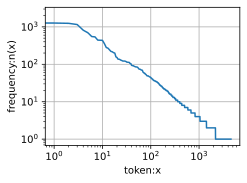

In [28]:
# 词频图
freqs = [freq for token,freq in vocab.token_freqs]
d2l.plot(freqs,xlabel='token:x',ylabel='frequency:n(x)',
         xscale='log',yscale='log')

In [29]:
bigram_tokens = [pair for pair in zip(corpus[:-1],corpus[1:])]
bigram_vocab = d2l.Vocab(bigram_tokens)
bigram_vocab.token_freqs[:10]

[(('of', 'the'), 309),
 (('in', 'the'), 169),
 (('i', 'had'), 130),
 (('i', 'was'), 112),
 (('and', 'the'), 109),
 (('the', 'time'), 102),
 (('it', 'was'), 99),
 (('to', 'the'), 85),
 (('as', 'i'), 78),
 (('of', 'a'), 73)]

In [30]:
# 值得注意的是：在10个最频繁的词对中，有九个是由2个停用词组成
# 只有一个与‘the time’有关，接下来看三元语法是否表现出相同的行为方式
trigram_tokens = [triple for triple in zip(
    corpus[:-2],corpus[1:-1],corpus[2:]
)]
trigram_vocab = d2l.Vocab(trigram_tokens)
trigram_vocab.token_freqs[:10]

[(('the', 'time', 'traveller'), 59),
 (('the', 'time', 'machine'), 30),
 (('the', 'medical', 'man'), 24),
 (('it', 'seemed', 'to'), 16),
 (('it', 'was', 'a'), 15),
 (('here', 'and', 'there'), 15),
 (('seemed', 'to', 'me'), 14),
 (('i', 'did', 'not'), 14),
 (('i', 'saw', 'the'), 13),
 (('i', 'began', 'to'), 13)]

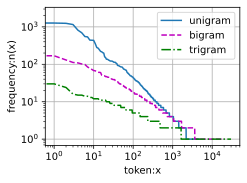

In [31]:
# 最直观的比较一元语法、二元语法和三元语法
bigram_freqs = [freq for token,freq in bigram_vocab.token_freqs]
trigram_freqs = [freq for token,freq in trigram_vocab.token_freqs]

d2l.plot([freqs,bigram_freqs,trigram_freqs],xlabel='token:x',
         ylabel='frequency:n(x)',xscale='log',yscale='log',
         legend=['unigram','bigram','trigram'])  #?

In [32]:
def seq_data_iter_random(corpus,batch_size,num_steps):
    corpus = corpus[random.randint(0,num_steps-1):]
    num_subseqs = (len(corpus)-1) // num_steps
    initial_indices = list(range(0,num_subseqs*num_steps,num_steps))
    random.shuffle(initial_indices)
    def data(pos):
        return corpus[pos:pos+num_steps]